In [1]:
# Import the necessary packages and data
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/processed/Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)

In [2]:
row_lengths = defaultdict(int)

for i, row in wq_df.iterrows():
    row_lengths[row.notnull().sum()] += 1

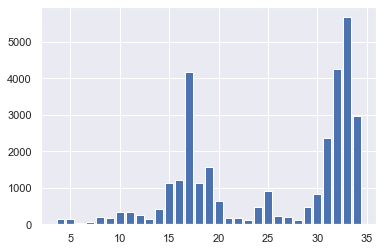

In [3]:
_ = plt.bar(x=row_lengths.keys(), height=row_lengths.values())

I want to use only rows with at least 30 columns complete. This is to prevent my data from being overloaded with imputed data.

In [4]:
for i, row in wq_df.iterrows():
    if row.notnull().sum() < 30:
        wq_df = wq_df.drop(index=i)

Next I will fill in blank values

In [5]:
ffill_df = pd.DataFrame()
for site in wq_df['Sampling Location'].unique():
    site_df = wq_df[wq_df['Sampling Location'] == site].sort_values(by='Sample Date')
    site_df = site_df.fillna(method='ffill')
    ffill_df = ffill_df.append(site_df)

In [6]:
final_df = pd.DataFrame()
for site in ffill_df['Sampling Location'].unique():
    site_df = ffill_df[ffill_df['Sampling Location'] == site].sort_values(by='Sample Date')
    site_df = site_df.fillna(method='bfill')
    final_df = final_df.append(site_df)

In [7]:
final_df = final_df.sort_index()
final_df = final_df.reset_index(drop=True)

Different parameters will serve different purposes in my analysis. Some measurements have standard limits that must not be exceeded. The rest of the columns will be potential indicators of poor water quality. I have outlined each column's limit/indicator status below:

- Water Temperature = Indicator

- Salinity = Indicator

- Conductivity = Indicator

- Dissolved Oxygen = 3.0 mg/L

- Light Transparency = Indicator

- Sigma-T = Indicator

- Secchi Depth = Indicator

- pH = 6.0 - 9.5

- Fecal Coliform = 2000 cells/100mL

- Enterococcus = 104 cells/100mL

- Ammonia = 2.0 mg/L

- Ortho-phosphate = 0.020 mg/L

- Kjeldahl Nitrogen = 10.0 mg/L

- Silica = Indicator

- Total Suspended Solids = Indicator

- Chlorophyll a = 30

- Dissolved Organic Carbon = Indicator


In [8]:
# Make functions to 
def check_do(measure):
    if measure < 3.0:
        return 1
    else:
        return 0
    
def check_pH(measure):
    if measure > 9.5 or measure < 6.5:
        return 1
    else:
        return 0
    
def check_fecal(measure):
    if measure > 2000:
        return 1
    else:
        return 0
    
def check_enter(measure):
    if measure > 104:
        return 1
    else:
        return 0
    
def check_nitrate(measure):
    if measure > 10:
        return 1
    else:
        return 0

def check_ammonia(measure):
    if measure > 2:
        return 1
    else:
        return 0
    
def check_phosphate(measure):
    if measure > 0.020:
        return 1
    else:
        return 0
    
def check_chloro(measure):
    if measure > 30:
        return 1
    else:
        return 0
    
# Make a dictionary of each parameter with limits and assign its check function   
check_funcs = {'Top Ammonium (mg/L)':check_ammonia,
               'Top Active Chlorophyll \'A\' (µg/L)':check_chloro,
               'CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)':check_do,
               'Top Enterococci Bacteria (Cells/100mL)':check_enter,
               'Top Fecal Coliform Bacteria (Cells/100mL)':check_fecal,
               'Top Total Kjeldhal Nitrogen (mg/L)':check_nitrate,
               'Top PH':check_pH,
               'Top Ortho-Phosphorus (mg/L)':check_phosphate
              }


In [9]:
# Create columns that signify whether a measurement is outside limits
fail_col = []
for col, func in check_funcs.items():
    new_col = col + ' Failure'
    fail_col.append(new_col)
    final_df[new_col] = final_df[col].apply(func)


Taking a look at the totals for each Failure column, the most common pollutant is Ortho-phophorus by a considerable margin followed by Chlorophull A and Enterococci. I'm going to investigate these three parameters in greater depth.

In [10]:
final_df.loc[:, fail_col].sum()

Top Ammonium (mg/L) Failure                                                               65
Top Active Chlorophyll 'A' (µg/L) Failure                                               2312
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure      742
Top Enterococci Bacteria (Cells/100mL) Failure                                          1498
Top Fecal Coliform Bacteria (Cells/100mL) Failure                                        918
Top Total Kjeldhal Nitrogen (mg/L) Failure                                                 3
Top PH Failure                                                                             6
Top Ortho-Phosphorus (mg/L) Failure                                                    15593
dtype: int64

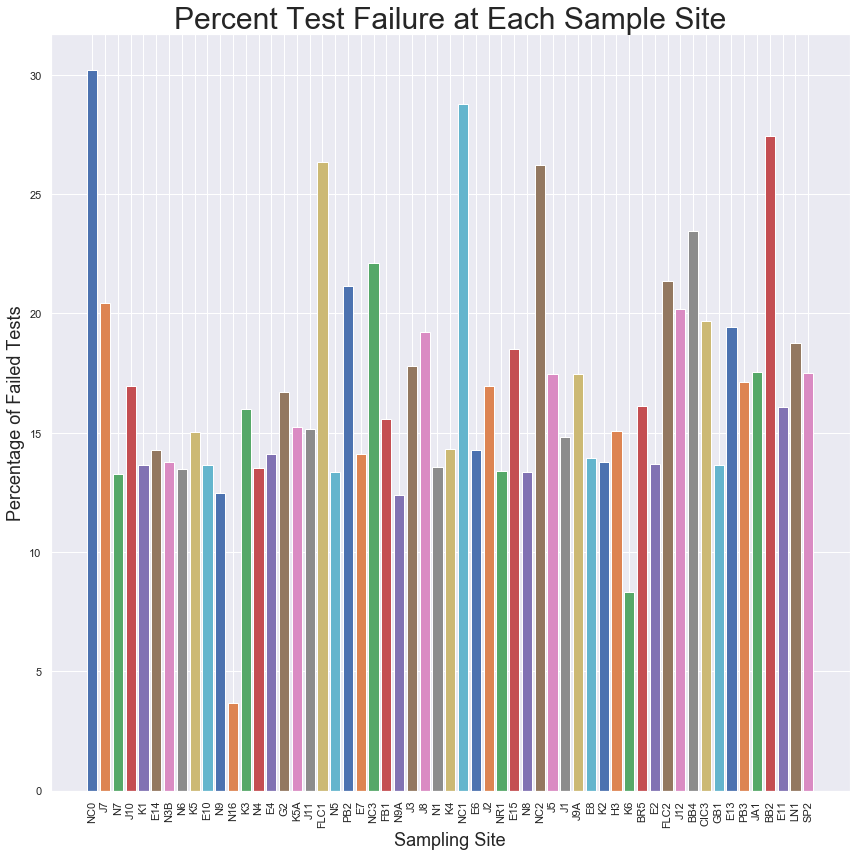

In [11]:
_ = plt.figure(figsize=(12, 12))

for location in final_df['Sampling Location'].unique():
    num = final_df[final_df['Sampling Location'] == location].loc[:, fail_col].sum().sum()
    den = final_df[final_df['Sampling Location'] == location].shape[0]
    ht = num / den / 8 * 100
    _ = plt.bar(x = location, 
            height = ht)

_ = plt.title('Percent Test Failure at Each Sample Site',
             fontsize=30)
_ = plt.xlabel('Sampling Site', fontsize=18)
_ = plt.ylabel('Percentage of Failed Tests', fontsize=18)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()